# Beginner's Experiment for Multi-input (Photo image + Meta data)

Thanks to Lonnie's notebook below. 
https://www.kaggle.com/lonnieqin/tensorflow-multi-input-pet-pawpularity-model

I tried to process simple Convolutional Neural Network (CNN) at first, but it didn't show good score. Then, I came to be interested in processing Multi-input using Photo image data and Meta data together, how good score it shows?  
最初はシンプルに畳み込みニューラルネットワークで画像認識をしたのですが、あまりスコアも良くないので、Meta Dataと一緒に処理したらどの程度のスコア改善に繋がるのか興味を持ち、Multi-inputの実験をしてみたものです。

**(1) Simple CNN using Photo-image data only**  
 First, I tried simple CNN using Photo-image data only. Public score was 20.73773.
 
**(2) Simple MLP using Meta-data only**  
 Then, tried simple MLP using Meta-data only. Public score was 20.61303.
 
**(3) Multi-input using both (1) and (2)**
 Tried Multi-input using both, then Public score was 20.53512.
 
Multi-input seems effective rather than processing each of them independently :-)

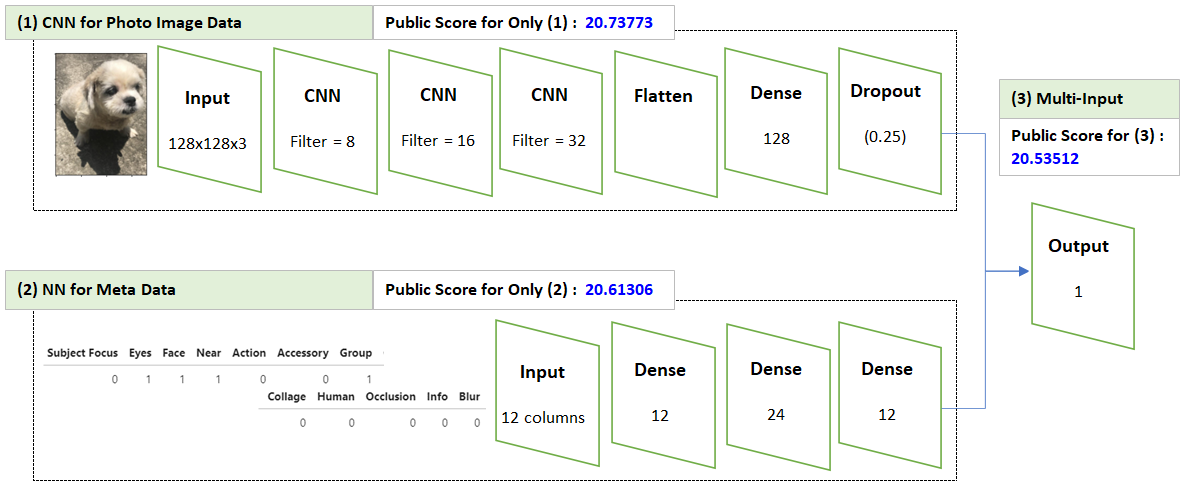




In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import cv2
import missingno as msno

In [ ]:
train=pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
test=pd.read_csv('../input/petfinder-pawpularity-score/test.csv')

In [ ]:
train.head()

In [ ]:
train_meta = train.copy()
test_meta = test.copy()
train_meta = train_meta.drop(["Id", "Pawpularity"], axis=1)
test_meta = test_meta.drop(["Id"], axis=1)

In [ ]:
train_image = train.copy()
test_image = test.copy()

train_image["file_path"] = train["Id"].apply(lambda x: "../input/petfinder-pawpularity-score/train/" + x + ".jpg")
test_image["file_path"] = test["Id"].apply(lambda x: "../input/petfinder-pawpularity-score/test/" + x + ".jpg")

In [ ]:
%%time

def preprocess(image_url):
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (128, 128))
    return image

x_train_image=[]
for i in train_image['file_path']:
    x1=preprocess(i)
    x_train_image.append(x1)

In [ ]:
plt.figure(figsize=(20, 20))
row, col = 5, 4
for i in range(row * col):
    plt.subplot(row, col, i+1)
    image = cv2.imread(train_image.loc[i, 'file_path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    target = train_image.loc[i, 'Pawpularity']
    plt.imshow(image)
    plt.title(f"No: {i}" f"   Pawpularity: {target}")
plt.show()

In [ ]:
test1_image=[]

for i in test_image['file_path']:
    x1=preprocess(i)
    test1_image.append(x1)

test1_image=np.array(test1_image)

In [ ]:
def get_model() :

    # model for Photo image
    image_inputs = tf.keras.Input((128, 128 , 3))
    x_image = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),strides=2,activation='relu', padding='same')(image_inputs)
    x_image = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),strides=2,activation='relu', padding='same')(x_image)
    x_image = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),strides=2,activation='relu', padding='same')(x_image)   
    x_image = tf.keras.layers.Flatten()(x_image)
    x_image = tf.keras.layers.Dense(128,activation='relu')(x_image)
    x_image = tf.keras.layers.Dropout(0.25)(x_image)
    
    # model for Meta data
    meta_inputs = tf.keras.Input(shape=((12,)))
    x_meta = tf.keras.layers.Dense(12,activation='relu')(meta_inputs)    
    x_meta = tf.keras.layers.Dense(24,activation='relu')(x_meta)    
    x_meta = tf.keras.layers.Dense(12,activation='relu')(x_meta)      

    x = tf.keras.layers.Concatenate(axis=1)([x_image, x_meta])
    output = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[image_inputs, meta_inputs], outputs=output)
    
    return model

In [ ]:
model =  get_model()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
x_train_image = np.array(x_train_image)
y_train=train['Pawpularity']

from sklearn.model_selection import train_test_split

import math
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, Callback

#x_meta_train,x_meta_test,y_train,y_test=train_test_split(train_meta,y_train,test_size=0.2)

In [ ]:
def preprocess1(image_url, tabular):
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (128, 128))
    return (image, tabular[1:]), tabular[0]

In [ ]:
%%time
tf.keras.backend.clear_session()

models = []
historys = []
tabular_columns = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 
                   'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
kf = KFold(n_splits=3, shuffle=True)

for train_index, val_index in kf.split(train_meta):      
    
    x_path = train_image.loc[train_index, "file_path"]    
    x_val= train_image.loc[val_index, "file_path"]
    
    tabular_train = train.loc[train_index, ["Pawpularity"] + tabular_columns]
    tabular_val = train.loc[val_index, ["Pawpularity"] + tabular_columns]

    def step_decay(epoch):
        initial_lrate = 0.001
        drop = 0.5
        epochs_drop = 10.0
        lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop)
        )
        return lrate

    lrate = LearningRateScheduler(step_decay)

    earstop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5)
    
    model = get_model()
    model.compile(
        loss = tf.keras.losses.MeanSquaredError(),    
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse"), "mae", "mape"],
        optimizer = tf.keras.optimizers.Adam(1e-3)
        )
    
    train_ds = tf.data.Dataset.from_tensor_slices((x_path, tabular_train)).map(preprocess1).shuffle(512).batch(100).cache().prefetch(2)
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, tabular_val)).map(preprocess1).batch(100).cache().prefetch(2)
    
    history = model.fit(
        train_ds,
        epochs = 25,
        batch_size=100,
        validation_data = val_ds,
        verbose = 1,
        callbacks = [lrate, earstop]
        )
        
    historys.append(history)
    models.append(model)

In [ ]:
def preprocess_test_data(image_url, tabular):    
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (128, 128))    
    return (image, tabular), 0

test_ds = tf.data.Dataset.from_tensor_slices((test_image["file_path"], test[tabular_columns])).map(preprocess_test_data).batch(100).cache().prefetch(2)

In [ ]:
preds = []

for model in models:
    nn_pred=model.predict(test_ds)
    preds.append(nn_pred)

preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis =0)

In [ ]:
sub=pd.DataFrame()
sub['Id']=test['Id']
sub['Pawpularity']=preds_mean
sub.to_csv('submission.csv',index=False)
sub

**(P.S.)**  
Below discussion thread was also helpful for me as a knowledge, but I was not able to utilize the method (Option1) very well.. (When I simply throw the Image+Meta into CNN, the Public score showed 22.19051...) I have to study more and retry :-)

なお、以下のリンクも非常に興味深かったのですが、ここで紹介されているOption1は、どうもうまく使いこなせませんでした（単純にImage+MetaをCNNに投入すると、スコアは22.19051でした。。）もっと研究してリトライせねば。

https://www.kaggle.com/c/petfinder-pawpularity-score/discussion/277164